In [1]:
!wget https://download.microsoft.com/download/3/6/c/36c17f9b-c2c3-40e4-98d8-cfdbd441441f/CHI2017_Krupka_and_Karmon_v1.zip

--2026-02-21 16:47:55--  https://download.microsoft.com/download/3/6/c/36c17f9b-c2c3-40e4-98d8-cfdbd441441f/CHI2017_Krupka_and_Karmon_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.38.253.179, 2600:1407:7400:1184::317f, 2600:1407:7400:1187::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.38.253.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2312517710 (2.2G) [application/octet-stream]
Saving to: ‘CHI2017_Krupka_and_Karmon_v1.zip’

CHI2017_Krupka_and_ 100%[===================>]   2.15G  9.98MB/s    in 3m 48s  

2026-02-21 16:51:43 (9.68 MB/s) - ‘CHI2017_Krupka_and_Karmon_v1.zip’ saved [2312517710/2312517710]



In [2]:
!unzip CHI2017_Krupka_and_Karmon_v1.zip

Streaming output truncated to the last 5000 lines.
  inflating: GestureClips/Clip_00136/Frame_01326_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01327_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01328_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01329_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01330_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01331_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01332_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01333_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01334_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01335_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01336_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01337_depth.png  
  inflating: GestureClips/Clip_00136/Frame_01338_depth.png  
   creating: GestureClips/Clip_00137/
  inflating: GestureClips/Clip_00137/Frame_00001_depth.png  
  inflating: GestureClips/Clip_00137/Frame_00002_depth.pn

In [3]:
!pip install opencv-python

In [16]:
!ls

CHI2017_Krupka_and_Karmon_v1.zip  Readme.docx	     ViewGestureClips.m
FingersData			  sample_data	     WorldPointsToImage.m
GestureClips			  ViewFingersData.m


In [56]:
import os

FINGERS_PATH = "/content/FingersData"
IMAGE_FOLDER = os.path.join(FINGERS_PATH, "Images")  # check case
print("Image folder exists:", os.path.isdir(IMAGE_FOLDER))

files = os.listdir(IMAGE_FOLDER)
print("Example image files:", files[:10])

Image folder exists: True
Example image files: ['df53c15604f65ec9_depth.png', '6daa1602e76f3327_depth.png', '6100e4d52f883c5b_depth.png', 'ef7adb937f26c3d3_depth.png', 'd1e295db979e9d7a_depth.png', '5c49eeb42de735e9_depth.png', '52b34e6fc56e4736_depth.png', '823e0265edfbbcf5_depth.png', '89f7a4e778f7b0ad_depth.png', '561b9453c172a84d_depth.png']


In [57]:
import scipy.io

MAT_FILE = "/content/FingersData/data.mat"
mat = scipy.io.loadmat(MAT_FILE)

keys = [k for k in mat.keys() if not k.startswith("__")]
print("MAT keys:", keys)

MAT keys: ['PerFrame', 'PerClip']


In [58]:
data = mat[keys[0]]  # frameData
print("Data dtype:", data.dtype)
print("Fields:", data.dtype.names)

Data dtype: [('ClipInd', 'O'), ('ImgUid', 'O'), ('DepthFileName', 'O'), ('InternalInd', 'O'), ('LandmarksXyzMm', 'O'), ('LandmarksImagePixel', 'O')]
Fields: ('ClipInd', 'ImgUid', 'DepthFileName', 'InternalInd', 'LandmarksXyzMm', 'LandmarksImagePixel')


In [59]:
import numpy as np

names = data['DepthFileName'].flatten()
landmarks = data['LandmarksImagePixel'].flatten()

print("Example image ref:", names[0])
print("Example landmark array shape:", landmarks[0].shape)

Example image ref: ['Images\\62609dfb95f7db94_depth.png']
Example landmark array shape: (2, 5)


In [62]:
label = "10178da9f3e1914a_depth.png".split('_')[0]

In [63]:
import cv2

images = []
landmarks_list = []
gesture_labels = []

image_files = sorted([f for f in os.listdir(IMAGE_FOLDER) if f.endswith(".png")])

for idx, file in enumerate(image_files):
    img_path = os.path.join(IMAGE_FOLDER, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128,128))
    images.append(img/255.0)

    landmarks_array = landmarks[idx]
    landmarks_flat = landmarks_array.flatten()
    landmarks_list.append(landmarks_flat)

    gesture_label = file.split("_")[0]
    gesture_labels.append(gesture_label)

images = np.array(images).reshape(-1,128,128,1)
landmarks_list = np.array(landmarks_list)
gesture_labels = np.array(gesture_labels)

print("Images:", images.shape)
print("Landmarks:", landmarks_list.shape)
print("Gesture labels:", np.unique(gesture_labels))

Images: (3500, 128, 128, 1)
Landmarks: (3500, 10)
Gesture labels: ['1003a9caeeec5c7e' '10080bd301a4bd92' '10178da9f3e1914a' ...
 'ff93df8f14c58010' 'ffcaecf01b63b162' 'ffe968e6a082bfaa']


In [64]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
gesture_encoded = le.fit_transform(gesture_labels)
gesture_cat = to_categorical(gesture_encoded)

print("Number of classes:", len(le.classes_))

Number of classes: 3500


In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, lm_train, lm_test = train_test_split(
    images, gesture_cat, landmarks_list,
    test_size=0.2, random_state=42
)

print("Train shapes:", X_train.shape, y_train.shape, lm_train.shape)
print("Test shapes:", X_test.shape, y_test.shape, lm_test.shape)

Train shapes: (2800, 128, 128, 1) (2800, 3500) (2800, 10)
Test shapes: (700, 128, 128, 1) (700, 3500) (700, 10)


In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_gesture = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model_gesture.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_gesture.summary()

history_gesture = model_gesture.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_test, y_test)
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3500)           │       451,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,843,244 (29.92 MB)

 Trainable params: 7,843,244 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 771ms/step - accuracy: 0.0000e+00 - loss: 8.1679 - val_accuracy: 0.0000e+00 - val_loss: 8.1990
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 65s 731ms/step - accuracy: 0.0000e+00 - loss: 8.1486 - val_accuracy: 0.0000e+00 - val_loss: 8.2683
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 748ms/step - accuracy: 0.0000e+00 - loss: 8.1332 - val_accuracy: 0.0000e+00 - val_loss: 8.3364
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 715ms/step - accuracy: 0.0000e+00 - loss: 8.1195 - val_accuracy: 0.0000e+00 - val_loss: 8.4033
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 736ms/step - accuracy: 9.7907e-04 - loss: 8.1074 - val_accuracy: 0.0000e+00 - val_loss: 8.4690
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 738ms/step - accuracy: 0.0000e+00 - loss: 8.0954 - val_accuracy: 0.0000e+00 - val_loss: 8.5333
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 716ms/step - accuracy: 0.0000e+00 - loss: 8.0846 - val_accuracy: 0.0000e+00 - val_loss: 8.5964
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 66s

In [67]:
loss, acc = model_gesture.evaluate(X_test, y_test)
print("Gesture test accuracy:", acc)

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.0000e+00 - loss: 9.0612
Gesture test accuracy: 0.0


In [68]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_img = Input(shape=(128,128,1))
x = Conv2D(32,(3,3),activation='relu')(input_img)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64,(3,3),activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
output_lm = Dense(landmarks_list.shape[1],activation='linear')(x)

model_lm = Model(input_img, output_lm)
model_lm.compile(optimizer='adam',loss='mse')

model_lm.summary()

history_lm = model_lm.fit(
    images, landmarks_list,
    epochs=20,
    validation_split=0.2
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,767,242 (56.33 MB)

 Trainable params: 14,767,242 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 939ms/step - loss: nan - val_loss: nan
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 919ms/step - loss: nan - val_loss: nan
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 996ms/step - loss: nan - val_loss: nan
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 947ms/step - loss: nan - val_loss: nan
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 140s 929ms/step - loss: nan - val_loss: nan
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 924ms/step - loss: nan - val_loss: nan
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 920ms/step - loss: nan - val_loss: nan
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 975ms/step - loss: nan - val_loss: nan
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 921ms/step - loss: nan - val_loss: nan
Epoch 10/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 921ms/step - loss: nan - val_loss: nan
Epoch 11/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 924ms/step - loss: nan - val_loss: nan
Epoch 12/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 917ms/step - loss: nan - val_loss: nan
Epoch 13/20
88/88 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


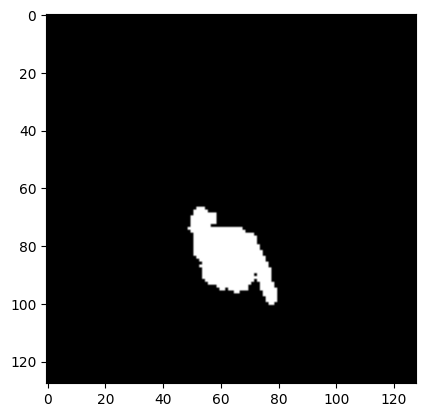

In [70]:
import matplotlib.pyplot as plt

idx = 10
pred_lm = model_lm.predict(images[idx:idx+1])[0]

plt.imshow(images[idx].reshape(128,128), cmap='gray')
xs = pred_lm[0::2]; ys = pred_lm[1::2]
plt.scatter(xs, ys, c='r')
plt.show()